# 数据说明
数据来源：[天池](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281978.0.0.68021b43DOhgme&postId=95422)

[数据详情](https://tianchi.aliyun.com/competition/entrance/231784/information)

> 本篇笔记的代码使用Jupyter Lab实现

## **参考资料**

[1] [Baseline方案](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281978.0.0.6802593aEHEy7Y&postId=95422)

[2] [赛题理解](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281978.0.0.6802593aEHEy7Y&postId=95456)

[3] [数据分析](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281978.0.0.6802593aEHEy7Y&postId=95457)

[4] [特征工程](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281978.0.0.6802593aEHEy7Y&postId=95501)

[5] [建模调参](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281978.0.0.6802593aEHEy7Y&postId=95460)

[6] [模型融合](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281978.0.0.6802593aEHEy7Y&postId=95535)

# 数据处理&分析

## 载入需要的模块

In [1]:
## 基础模块
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb

## 降维
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, SparsePCA

## 网格搜索、模型评估
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 载入数据

In [2]:
## 读取数据
train_data = pd.read_csv("used_car_train_20200313.csv", sep=" ")
testB_data = pd.read_csv("used_car_testB_20200421.csv", sep=" ")

## 训练集大小
print("Train data shape:", train_data.shape)

Train data shape: (150000, 31)


In [3]:
## 测试集大小
print("TestB data shape:", testB_data.shape)

TestB data shape: (50000, 30)


## 数据预览

In [4]:
train_data.head()  ## 预览前5行

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
train_data.tail()  ## 预览最后5行

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
149995,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014
149999,149999,177672,19990204,19.0,28,6.0,0.0,1.0,193,12.5,...,0.284475,0.000000,0.040072,0.062543,0.025819,1.978453,-3.179913,0.031724,-1.483350,-0.342674


In [6]:
## .info()简要查看每列对应的数据类型、非缺失样本量
train_data.info()
## 总共有150000个样本量
## 149999表明'model'列有1个缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [7]:
train_data.columns  ## 查看所有列名

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [8]:
testB_data.info()
## 测试集有50000个样本

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48496 non-null float64
fuelType             47076 non-null float64
gearbox              48032 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

In [9]:
## 描述性统计
train_data.describe()
## 查看每列的非空样本量、均值mean、标准差std、最小值min、25%分位数、
## 中位数（即50%分位数）、75%分位数、最大值max

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [10]:
testB_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,48496.000000,47076.000000,48032.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.793736,0.376498,0.226953,119.766960,12.598260,...,0.248147,0.044624,0.124693,0.058198,0.062113,0.019633,0.002759,0.004342,0.004570,-0.007209
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,1.764970,0.549281,0.418866,206.313348,3.912519,...,0.045836,0.051664,0.201440,0.029171,0.035723,3.764095,3.289523,2.515912,1.287194,1.044718
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.119719,-5.662163,-8.291868,-4.157649,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243436,0.000035,0.062519,0.035413,0.033880,-3.675196,-1.963928,-1.865406,-1.048722,-0.440706
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257818,0.000801,0.095880,0.056804,0.058749,1.632134,-0.375537,-0.138943,-0.036352,0.136849
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265263,0.101654,0.125470,0.079387,0.087624,2.846205,1.263451,1.775632,0.945239,0.685555
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000,6.000000,1.000000,19211.000000,15.000000,...,0.291176,0.153403,1.411559,0.157458,0.211304,12.177864,18.789496,13.384828,5.635374,2.649768


## 数据特征

In [11]:
## 提取数值型特征列名
numerical_cols = train_data.select_dtypes(exclude='object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [12]:
## 提取非数值型特征列名
categorical_cols = train_data.select_dtypes(include='object').columns
print(categorical_cols)

Index(['notRepairedDamage'], dtype='object')


## 训练集和测试集

In [13]:
## 选择特征列
feature_cols = [col for col in numerical_cols if col not in ['SaleID', 'name', 'regDate','creatDate','price','model','brand','regionCode','seller']]
feature_cols = [col for col in feature_cols if 'Type' not in col]

In [14]:
## 提取特征列、标签列构造训练集和测试集
X_train = train_data[feature_cols]  ## 训练集特征
y_train = train_data['price']  ## 训练集标签

X_test = testB_data[feature_cols]  ## 测试集标签

print('X train shape is :', X_train.shape)
print('X test shape is :', X_test.shape)

X train shape is : (150000, 18)
X test shape is : (50000, 18)


In [15]:
## 统计标签的基本分布信息
def stat_info(data):
    print('_min', np.min(data))
    print('_max', np.max(data))
    print('_mean', np.mean(data))
    print('_ptp', np.ptp(data))  ## 最大值与最小值的差
    print('_std', np.std(data))
    print('_var', np.var(data))

print('Stat of label:')
stat_info(y_train)

Stat of label:
_min 11
_max 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876438
_var 56279605.94272992


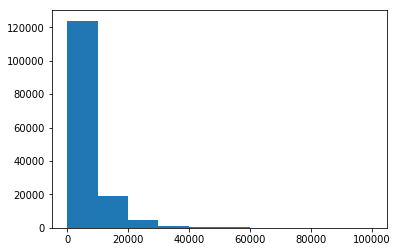

In [16]:
## label中可能存在异常大值
## 绘制标签的直方图，查看标签分布
plt.hist(y_train)
plt.show()
plt.close()

In [17]:
## 填补缺失值
X_train = X_train.fillna(-1)  ## 用-1填补
X_test = X_test.fillna(-1)

# 模型

In [18]:
## 利用XGBoost进行5折交叉验证
xgb_reg = xgb.XGBRegressor(
    n_estimators=120, 
    learning_rate=0.1, 
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.9,
    max_depth=7,
    objective='reg:squarederror'
)
scores_train = []
scores = []

## 5折交叉验证
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_idx, val_idx in folds.split(X_train, y_train):
    train_X = X_train.iloc[train_idx].values
    train_y = y_train.iloc[train_idx]
    val_X = X_train.iloc[val_idx].values
    val_y = y_train.iloc[val_idx]
    
    xgb_reg.fit(train_X, train_y)
    pred_train_y_xgb = xgb_reg.predict(train_X)
    pred_val_y_xgb = xgb_reg.predict(val_X)
    
    score_train = mean_absolute_error(train_y, pred_train_y_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y, pred_val_y_xgb)
    scores.append(score)
    
print('Train MAE:', np.mean(score_train))
print('Validation MAE:', np.mean(scores))

Train MAE: 622.8334142499367
Validation MAE: 713.7602744693083


In [19]:
## 定义xgb和lgb模型函数
def XGB_model(x_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=150,
        learning_rate=0.1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.9,
        max_depth=7,
        objective='reg:squarederror'
    )
    model.fit(x_train, y_train)
    return model

def LGB_model(x_train, y_train):
    estimator = lgb.LGBMRegressor(
        num_leaves=127,
        n_estimators=150
    )
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [20]:
## 切分训练集和验证集
x_train, x_val, yy_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [21]:
print("Training LGB ...")
model_lgb = LGB_model(x_train, yy_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val, val_lgb)
print("MAE of val with LGB:", MAE_lgb)

print("Predict LGB ...")
model_lgb_pred = LGB_model(X_train, y_train)
subB_lgb = model_lgb_pred.predict(X_test)
print("stat of Predict LGB:")
stat_info(subB_lgb)

Training LGB ...
MAE of val with LGB: 687.1736052804791
Predict LGB ...
stat of Predict LGB:
_min -589.8793550785414
_max 90760.26063584947
_mean 5906.935218383807
_ptp 91350.13999092802
_std 7344.644970956768
_var 53943809.749400534


In [22]:
print("Training XGB ...")
model_xgb = XGB_model(x_train, yy_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val, val_xgb)
print("MAE of val with xgb:", MAE_xgb)

print("Predict xgb ...")
model_xgb_pred = XGB_model(X_train, y_train)
subB_xgb = model_xgb_pred.predict(X_test)
print("Stat of Predict XGB:")
stat_info(subB_xgb)

Training XGB ...
MAE of val with xgb: 713.8987584188461
Predict xgb ...
Stat of Predict XGB:
_min -318.2115
_max 90140.625
_mean 5910.76
_ptp 90458.836
_std 7345.9653
_var 53963204.0


In [23]:
## 加权融合两模型的结果
val_weighted = (1 - MAE_lgb / (MAE_xgb + MAE_lgb)) * val_lgb + (1 - MAE_xgb / (MAE_xgb + MAE_lgb) * val_xgb)
val_weighted[val_weighted < 0] = 10  ## 修正预测值为负的样本
print("MAE of val with weighted ensemble:", mean_absolute_error(y_val, val_weighted))

MAE of val with weighted ensemble: 5888.071354671169


In [24]:
sub_weighted = (1 - MAE_lgb / (MAE_xgb + MAE_lgb)) * subB_lgb + (1 - MAE_xgb / (MAE_xgb + MAE_lgb)) * subB_xgb

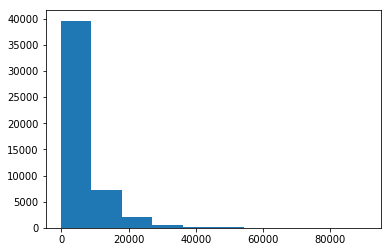

In [25]:
## 查看预测值的直方图
plt.hist(sub_weighted)
plt.show()
plt.close()

# 输出结果

In [26]:
sub = pd.DataFrame()
sub['SaleID'] = testB_data.SaleID
sub['price'] = sub_weighted
sub.to_csv("./sub_weighted.csv", index=False)

In [27]:
sub.head()  ## 预览结果

,SaleID,price
0,200000,1177.409043
1,200001,1806.548102
2,200002,8560.376569
3,200003,1346.403363
4,200004,2074.413901
